<a href="https://colab.research.google.com/github/itchyfeet-patient/kaggle-transcription/blob/master/A_simple_nn_solution_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* [원 노트북](https://www.kaggle.com/code/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl/notebook)  
* [캐글 대회](https://www.kaggle.com/competitions/mercari-price-suggestion-challenge)

# **A simple nn solution with Keras**

## 👑 Competition : Mercari Price Suggestion Challenge

'메루카리' 라는 일본 최대 중고거래 사이트에서 개최한 Competition입니다.  
![image](https://user-images.githubusercontent.com/108614874/196069399-ff25e929-4d07-4127-817b-8f468e3505cb.png)
이 스웨터 중 하나는 335 달러고 다른 스웨터는 9.99 달러입니다.  
이 중 어느것이 더 비싼 제품인지 맞출 수 있을까요?  
의류는 계절별 가격 추세가 강하고 브랜드 이름의 영향을 많이 받는 반면, 전자제품은 제품 사양에 따라 가격이 변동합니다. 이렇게 제품별로 고려해야 할 사항이 각기 다르기 때문에 중고거래가를 제시하는데 어려움이 있습니다.  
여기서 메루카리는 올바른 제품 가격을 자동으로 제안하는 알고리즘을 구축하도록 Competition을 제안했습니다.

---

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation에서 수정

import matplotlib.pyplot as plt
%matplotlib inline

import math

from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/dataset/kaggle/mercari-price-suggestion-challenge"]).decode("utf8"))

myNNsubmission.csv
nn_model.h5
sample_submission.csv
test.tsv
train.tsv



이렇게 경로에 있는 파일을 확인하고 라이브러리를 불러왔습니다.

### RMSLE 함수

![image](https://user-images.githubusercontent.com/108614874/196071122-c562e922-9708-4030-8a01-6d807b1e5bde.png)

이 competition에서는 RMSLE로 채점을 합니당

In [ ]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

#Source: https://www.kaggle.com/marknagelberg/rmsle-function

### 데이터 불러오기

In [ ]:
# Load data
print("loading data...")
train = pd.read_table("/content/drive/MyDrive/dataset/kaggle/mercari-price-suggestion-challenge/train.tsv")
test = pd.read_table("/content/drive/MyDrive/dataset/kaggle/mercari-price-suggestion-challenge/test.tsv")
print(train.shape)
print(test.shape)

loading data...
(1482535, 8)
(693359, 7)



* `train_id` or `test_id`
* `name` - 제품명이고, 이름에 가격이 포함되어 있으면 [rm]으로 대체할 예정
* `item_condition_id` - 판매자가 제공한 제품 상태
* `category_name`
* `brand_name`
* `price` - 판매'된' 가격 , target variable이고 우리가 예측해야 할 대상, 단위는 USD, 당연히 test.tsv에 존재하지않음.
* `shipping` - 배송료를 판매자가 지불했으면 1, 구매자가 지불했으면 0
* `item_description` - 항목 설명, 가격이 포함된 데이터는 [rm]으로 표시될거에요

In [ ]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
test.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


### 결측치 다루기

In [ ]:
# handle missing values
print("handling missing values..")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

handling missing values..
(1482535, 8)
(693359, 7)


In [ ]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


결측치를 `missing`으로 잘 대체했습니다.

### 범주 데이터 처리

In [ ]:
train.category_name

0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
                                 ...                        
1482530                               Women/Dresses/Mid-Calf
1482531                             Kids/Girls 2T-5T/Dresses
1482532       Sports & Outdoors/Exercise/Fitness accessories
1482533                   Home/Home Décor/Home Décor Accents
1482534                    Women/Women's Accessories/Wallets
Name: category_name, Length: 1482535, dtype: object

In [ ]:
test.category_name

0                                       Women/Jewelry/Rings
1                   Other/Office supplies/Shipping Supplies
2            Vintage & Collectibles/Bags and Purses/Handbag
3                                   Women/Sweaters/Cardigan
4                       Other/Books/Religion & Spirituality
                                ...                        
693354                   Home/Home Décor/Home Décor Accents
693355                            Beauty/Makeup/Makeup Sets
693356    Electronics/Cell Phones & Accessories/Cases, C...
693357                             Women/Swimwear/Cover-Ups
693358                        Women/Tops & Blouses/T-Shirts
Name: category_name, Length: 693359, dtype: object

In [ ]:
print(np.hstack([train.category_name, test.category_name]))

['Men/Tops/T-shirts' 'Electronics/Computers & Tablets/Components & Parts'
 'Women/Tops & Blouses/Blouse' ...
 'Electronics/Cell Phones & Accessories/Cases, Covers & Skins'
 'Women/Swimwear/Cover-Ups' 'Women/Tops & Blouses/T-Shirts']


In [ ]:
# Process Categorical data
print('handling categorical variables...')
le = LabelEncoder()

# category name
le.fit(np.hstack([train.category_name, test.category_name]))
# train, test의 category name을 가로로 합쳐서 피팅
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)
# 라벨링해줌

# brand name
le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


category name과 brand_name이 잘 라벨링 됐습니다.

### 텍스트 다루기 : 토큰화

문장으로 되어 있는 item description과 name은 token화 시켜줍니다.

In [ ]:
# process text : RAW
print("text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])
# 소문자로 변환해서 가로로 쌓아줌

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
# 가로로 쌓은거 토큰화
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
# tokenize한 것들로 sequences로 바꿔줍니다.
train.head(3)

text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


새로 추가된 열을 보면 토큰화된 단어들을 이용, 시퀀스로 잘 변환된 것을 확인할 수 있습니다.

### 시퀀스 변수 분석

In [ ]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
# train, test각각 seq로 변환된 name의 개수 세서 그중 최대값 구하고 그 둘중 최종 최대값을 구함
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
# item description도 마찬가지
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


In [ ]:
train.seq_name.apply(lambda x: len(x))

0          7
1          4
2          3
3          3
4          4
          ..
1482530    4
1482531    4
1482532    7
1482533    3
1482534    6
Name: seq_name, Length: 1482535, dtype: int64

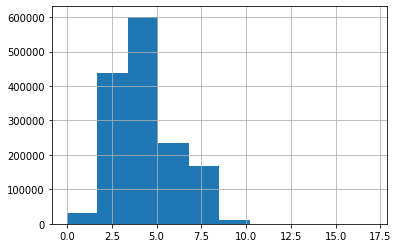

In [ ]:
train.seq_name.apply(lambda x: len(x)).hist()

train 데이터의 seq_name 분포도를 보여주는 히스토그램입니다.  
길이가(단어개수가) 5정도인 시퀀스들이 많은 것을 알 수 있습니다.

In [ ]:
train.seq_item_description.apply(lambda x: len(x))

0           3
1          36
2          29
3          32
4           5
           ..
1482530    22
1482531     8
1482532     8
1482533    28
1482534    11
Name: seq_item_description, Length: 1482535, dtype: int64

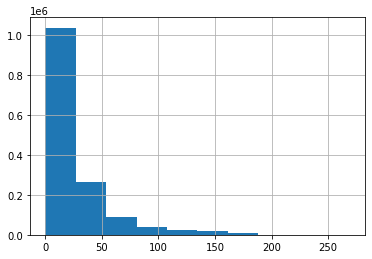

In [ ]:
train.seq_item_description.apply(lambda x : len(x)).hist()

train 데이터의 seq_item_decription 분포입니다.  
여기서는 길이가 10~25 사이값이 가장 많고 분포가 넓은편입니다.

### Embeddings max value

In [ ]:
# Embedding max value
# base on the histograms, we select the next lengths
# 위에서 구한 히스토그램을 바탕으로 max length를 설정해주겠어요
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())                 
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

왜 1? 2? 더해줌?

In [ ]:
MAX_TEXT, MAX_BRAND, MAX_CATEGORY, MAX_CONDITION

(259088, 5290, 1311, 6)

### target 변수를 scale해주자

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb52f79e690>]],
      dtype=object)

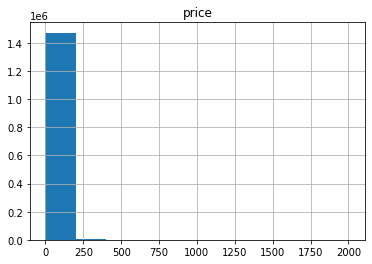

In [ ]:
pd.DataFrame(train.price).hist()

price가 너무 치우쳐있어요

In [ ]:
train.price

0          10.0
1          52.0
2          10.0
3          35.0
4          44.0
           ... 
1482530    20.0
1482531    14.0
1482532    12.0
1482533    45.0
1482534    22.0
Name: price, Length: 1482535, dtype: float64

In [ ]:
a = np.log(train.price+1)
a

0          2.397895
1          3.970292
2          2.397895
3          3.583519
4          3.806662
             ...   
1482530    3.044522
1482531    2.708050
1482532    2.564949
1482533    3.828641
1482534    3.135494
Name: price, Length: 1482535, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5524a7290>]],
      dtype=object)

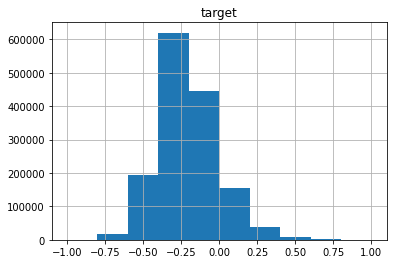

In [ ]:
#SCALE target variable
train["target"] = np.log(train.price+1)
# 정규분포화하기위해 log(1+x)를 취해줬습니다. 

target_scaler = MinMaxScaler(feature_range=(-1, 1))
# MiinMaxScaler로 0과 1사이 값으로 정규화시켜줬습니다.
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()

train.target 이 series 자료형이라 reshape이 안돼서 values를 넣어줬당  

[참고](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.reshape.html#pandas.Series.reshape)

정규화와 정규분포화가 잘 된것을 볼 수 있습니다.

### 학습데이터, 훈련데이터 분리

In [ ]:
dtrain, dvalid = train_test_split(train, random_state = 123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


train:valid = 99:1 로 분할해줬습니다.

### padding!

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tensorflow. 빠져있었다!

def get_keras_data(dataset):
    X = {
        'name' : pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        , 'item_desc' : pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        , 'brand_name' : np.array(dataset.brand_name)
        , 'category_name' : np.array(dataset.category_name)
        , 'item_condition' : np.array(dataset.item_condition_id)
        , 'num_vars' : np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

dtrian, dvalid, test 각각에 필요한 column을 넣어주는데, name과 item_desc 은 padding을 해줍니다

In [ ]:
dtrain.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target
407853,407853,maroon velvet lisette shorts,1,1162,737,22.0,1,brand new from brandy melville,"[16, 5, 43, 536, 587]","[836, 1038, 18025, 129]",-0.175509
748699,748699,Benefit Roller Lash Mascara FULL SIZE,2,26,574,14.0,1,Benefit Roller Lash Mascara FULL SIZE in the c...,"[1232, 2593, 1292, 643, 152, 6, 7, 2, 48, 24, ...","[1232, 2593, 1292, 643, 152, 6]",-0.287907
320295,320295,Holographic Ipsy Bag,2,1303,5265,7.0,0,Used once,"[31, 96]","[2875, 2240, 101]",-0.453202


### 모델 만들기~

In [ ]:
# Keras Model definition
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience = patience, mode = "min")
    msave = ModelCheckpoint(filepath, save_best_only =True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1. )
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1 # dropout rate

    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name = "brand_name")
    category_name = Input(shape=[1], name = "category_name")
    item_condition = Input(shape=[1], name ="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)

    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    # item desc 랑 name은 gru 넣어주고

    # main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    # 다합쳐줌
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))

    # output
    output = Dense(1, activation = "linear") (main_l)

    # model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])

    return model

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

### 모델 학습~

In [ ]:
# Fitting the model
model_path = "/content/drive/MyDrive/dataset/kaggle/mercari-price-suggestion-challenge/nn_model.h5"

BATCH_SIZE = 20000
epochs = 20
model = get_model()
model.fit(X_train, dtrain.target, epochs = epochs, batch_size=BATCH_SIZE
          , validation_data = (X_valid, dvalid.target)
          , verbose = 1)

model.save(model_path)

Epoch 1/20
74/74 [==============================] - 17s 108ms/step - loss: 0.0278 - mae: 0.1267 - rmsle_cust: 0.0153 - val_loss: 0.0182 - val_mae: 0.1020 - val_rmsle_cust: 0.0136
Epoch 2/20
74/74 [==============================] - 7s 98ms/step - loss: 0.0178 - mae: 0.1010 - rmsle_cust: 0.0132 - val_loss: 0.0159 - val_mae: 0.0957 - val_rmsle_cust: 0.0126
Epoch 3/20
74/74 [==============================] - 7s 98ms/step - loss: 0.0156 - mae: 0.0947 - rmsle_cust: 0.0124 - val_loss: 0.0155 - val_mae: 0.0949 - val_rmsle_cust: 0.0124
Epoch 4/20
74/74 [==============================] - 7s 99ms/step - loss: 0.0147 - mae: 0.0918 - rmsle_cust: 0.0121 - val_loss: 0.0154 - val_mae: 0.0943 - val_rmsle_cust: 0.0124
Epoch 5/20
74/74 [==============================] - 7s 99ms/step - loss: 0.0141 - mae: 0.0899 - rmsle_cust: 0.0119 - val_loss: 0.0153 - val_mae: 0.0942 - val_rmsle_cust: 0.0124
Epoch 6/20
74/74 [==============================] - 7s 100ms/step - loss: 0.0136 - mae: 0.0880 - rmsle_cust: 0.01

In [ ]:

# Evauate The model on dev Test : What is it Doing??
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds) + 1

# mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: " +str(v_rmsle))


464/464 [==============================] - 2s 4ms/step
 RMSLE error on dev test: 0.485428879640637


원 노트북 : 0.4894767455336322

In [ ]:
# Create Predictions
preds = model.predict(X_test, batch_size = BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

35/35 [==============================] - 1s 22ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
submission.head(5)

,test_id,price
0,0,10.098969
1,1,10.376454
2,2,40.875351
3,3,15.096447
4,4,13.848146


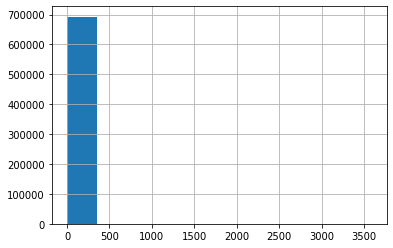

In [ ]:
submission.to_csv("/content/drive/MyDrive/dataset/kaggle/mercari-price-suggestion-challenge/myNNsubmission.csv", index=False)
submission.price.hist()


- Increase the embeddings factors
- Decrease the batch size
- Add Batch Normalization
- Try LSTM, Bidirectional RNN, stack RNN
- Try with more dense layers or more rnn outputs
-  etc. Or even try a new architecture!